<a href="https://colab.research.google.com/github/bitswired/bitsof-ai/blob/main/projects/debug-models-with-overfitting/Debug_Machine_Learning_Models_With_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Debug Machine Learning Models With Overfitting

## Download and import libraries

In [ ]:
!pip install pytorch-lightning
!pip install torchdata

In [ ]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt

import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchdata.datapipes as dp
from torchdata.datapipes.iter import IterableWrapper

In [ ]:
plt.style.use('dark_background')

plt.rcParams.update({
    "figure.facecolor":  "#383838",
    "axes.facecolor":    "#383838"
})

## Build a dummy dataset and create a loading pipeline with TorchData

The data will simply be a sin function with some noise.

In [ ]:
def get_data_pipe(n_samples=1000, batch_size=10):
    """Function to get a data pipeline"""
    dp = (
        # Generate X data, eveleny spaced number betwwen 0 and 4
        IterableWrapper(np.linspace(0, 4, n_samples, dtype=np.float32))
        .map(lambda x: x.reshape(-1, 1))
        # Rescale x between -1 and 1 and compute y = sin(x) + noise
        .map(lambda x: (x / 2 - 1 , np.sin(x * 4) + np.random.randn()/10))
        # Shuffle the data
        .shuffle()
        # Batch the data
        .batch(batch_size)
        # Collate to transform list of tuples to a tuple of tensors (x, y)
        .collate()
    )

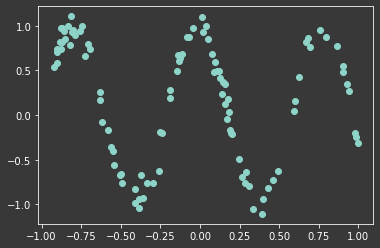

In [ ]:
# Plot samples from the data pipe

pipe = get_data_pipe(batch_size=100)
batch = list(it.islice(pipe, 3))[0]
x, y = batch

plt.scatter(x, y)
plt.show()

## Modeling

### PyTorch Module

We first build a simple PyTorch module, a neural net with 3 layers.

It takes a parameter `with_error` to make voluntarily an error or not. 

It will be used to illustrate how overfitting can detect a buggy model.


In [ ]:
class SimpleNeuralNet(nn.Module):
    """PyTorch module to predict the sinusoidal data"""
    def __init__(self, with_error=False):
        super().__init__()
        # Make a mistake volontarily
        # The mistake is the use of the last ReLU activation
        # It will make the model output only positive vales whereas sin 
        # can output negative values as well
        # This kind of bug can be easy to miss when reading the code
        if with_error:
            self.layers = nn.Sequential(
                nn.Linear(1, 50),
                nn.ReLU(),
                nn.Linear(50, 50),
                nn.ReLU(),
                nn.Linear(50, 1),
                nn.ReLU(),
            )
        # Don't make the mistake
        else:
            self.layers = nn.Sequential(
                nn.Linear(1, 50),
                nn.ReLU(),
                nn.Linear(50, 50),
                nn.ReLU(),
                nn.Linear(50, 1)
            )

### PyTorch Lightning Module

We create a `LightningModule` to encapsulate the training logic for our model.

It also takes a paremeter to decide if it will be an erroneous model or not.

It uses the PyTorch module to make the prediction.

In [ ]:
class Model(pl.LightningModule):
    def __init__(self, with_error=False):
        super().__init__()
        self.neural_net = SimpleNeuralNet(with_error)

    def forward(self, x):
        return self.neural_net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = (x.squeeze(0), y.squeeze(0))
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y.squeeze(0))
        return loss

## Detect the error with overfitting

In [ ]:
class MetricTracker(pl.Callback):
    """Custom callback to save the training loss per training steps"""
    def __init__(self):
        self.collection = []
    
    def on_train_batch_end(self, trainer, module, outputs, *args):
        loss = outputs['loss']
        self.collection.append(loss.cpu())

In [ ]:
def overfit_and_get_averaged_loss(model):
    """Function to overfit the model on a small set of data and return
       loss per steps to determine if there is a bug or not"""
    # Seed for reproducibility
    pl.seed_everything(7, workers=True)
    # Create a metric tracker to get back the loss for each step after training
    metric_tracker = MetricTracker()
    # Create a dataloader for training
    train_loader = DataLoader(get_data_pipe(n_samples=1000, batch_size=20))
    # Creaate a trainer to overfit 10% of the data 
    trainer = pl.Trainer(overfit_batches=0.1, callbacks=[metric_tracker])
    # Train the model (try to overfit 10% of the data)
    trainer.fit(model, train_dataloaders=train_loader)

    # Return the moving average over the loss with a window of 100 steps
    N = 100
    loss_running_mean = np.convolve(metric_tracker.collection, np.ones(N)/N, mode='valid')
    return loss_running_mean

### Overfitting 10% of the training data

In [ ]:
# We create one buggy and one working model
model_with_error = Model(with_error=True)
model_without_error = Model(with_error=False)

# We try to overfit the each model on a small set of training data and get back
# the loss for each training steps averaged with a window of 100
loss_with_error = overfit_and_get_averaged_loss(model_with_error)
loss_without_error = overfit_and_get_averaged_loss(model_without_error)

Global seed set to 7
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type            | Params
-----------------------------------------------
0 | neural_net | SimpleNeuralNet | 2.7 K 
-----------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:472: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  "You requested to overfit but enabled

Training: 0it [00:00, ?it/s]

Global seed set to 7
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type            | Params
-----------------------------------------------
0 | neural_net | SimpleNeuralNet | 2.7 K 
-----------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

### Analyze the overfitting resutls for the buggy and the working models

You can observe the results after overfitting a small set of training data for buggy and the working models.

**Buggy model**: the model is not improving over time, showing that something is wrong.

**Working model**: the loss rapidly decreases showing that the model is learning.

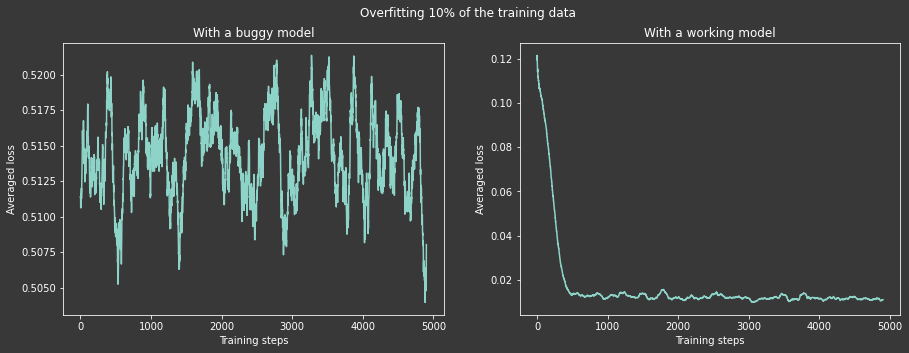

In [ ]:
# Here we plot the running loss for the buggy and the working

fig, axes = plt.subplots(1, 2, figsize=(15,5))

fig.suptitle("Overfitting 10% of the training data")


axes[0].plot(loss_with_error)
axes[0].set_title("With a buggy model")
axes[0].set_xlabel("Training steps")
axes[0].set_ylabel("Averaged loss")

axes[1].plot(loss_without_error)
axes[1].set_title("With a working model")
axes[1].set_xlabel("Training steps")
axes[1].set_ylabel("Averaged loss")


plt.show()

